<a href="https://colab.research.google.com/github/data2450/air_qulity_pr_zindi_ch/blob/main/AirQo_Low_Cost_Air_Quality_Monitor_Calibration_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
#from supervised.automl import AutoMl


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/S/Train (1).csv')
ts=pd.read_csv('/content/drive/MyDrive/S/Test (1).csv')


In [ ]:
train['pa']=1
ts['pa']=0

In [ ]:
train.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,pa
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,1
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,1
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,1
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,1
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10932 entries, 0 to 10931
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10932 non-null  object 
 1   created_at       10932 non-null  object 
 2   site             10932 non-null  object 
 3   pm2_5            10932 non-null  float64
 4   pm10             10932 non-null  float64
 5   s2_pm2_5         10932 non-null  float64
 6   s2_pm10          10932 non-null  float64
 7   humidity         10926 non-null  float64
 8   temp             10915 non-null  float64
 9   lat              10932 non-null  float64
 10  long             10932 non-null  float64
 11  altitude         10932 non-null  int64  
 12  greenness        10932 non-null  int64  
 13  landform_90m     10932 non-null  int64  
 14  landform_270m    10932 non-null  int64  
 15  population       10932 non-null  int64  
 16  dist_major_road  10932 non-null  int64  
 17  ref_pm2_5   

In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2733 entries, 0 to 2732
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2733 non-null   object 
 1   created_at       2733 non-null   object 
 2   site             2733 non-null   object 
 3   pm2_5            2733 non-null   float64
 4   pm10             2733 non-null   float64
 5   s2_pm2_5         2733 non-null   float64
 6   s2_pm10          2733 non-null   float64
 7   humidity         2732 non-null   float64
 8   temp             2729 non-null   float64
 9   lat              2733 non-null   float64
 10  long             2733 non-null   float64
 11  altitude         2733 non-null   int64  
 12  greenness        2733 non-null   int64  
 13  landform_90m     2733 non-null   int64  
 14  landform_270m    2733 non-null   int64  
 15  population       2733 non-null   int64  
 16  dist_major_road  2733 non-null   int64  
 17  pa            

In [ ]:
ts.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,pa
0,ID_00OZLF7X,2020-03-13 07:00:00+03:00,USEmbassy,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130,0
1,ID_00ZI0D98,2020-08-08 10:00:00+03:00,Makerere,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475,0
2,ID_017GTLAU,2020-08-25 09:00:00+03:00,Makerere,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475,0
3,ID_01IBM7T2,2020-06-15 16:00:00+03:00,USEmbassy,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130,0
4,ID_01II27D4,2021-01-13 00:00:00+03:00,Nakawa,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500,0


# lets do feature engeering first  

In [ ]:
all_data=pd.concat((train,ts)).reset_index(drop=True)
print('shape :', all_data.shape )

shape : (13665, 19)


In [ ]:
#split out created_at column

all_data['year']=pd.to_datetime(all_data['created_at']).dt.year

all_data['month']=pd.to_datetime(all_data['created_at']).dt.month

all_data['hour']=pd.to_datetime(all_data['created_at']).dt.hour



In [ ]:
all_data['date']=pd.to_datetime(all_data['created_at']).dt.day

In [ ]:
all_data.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,pa,year,month,hour,date
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,1,2020,4,17,23
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,1,2020,2,19,23
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,1,2021,1,4,23
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,1,2019,12,9,4
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,1,2019,10,1,1


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13665 entries, 0 to 13664
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               13665 non-null  object 
 1   created_at       13665 non-null  object 
 2   site             13665 non-null  object 
 3   pm2_5            13665 non-null  float64
 4   pm10             13665 non-null  float64
 5   s2_pm2_5         13665 non-null  float64
 6   s2_pm10          13665 non-null  float64
 7   humidity         13658 non-null  float64
 8   temp             13644 non-null  float64
 9   lat              13665 non-null  float64
 10  long             13665 non-null  float64
 11  altitude         13665 non-null  int64  
 12  greenness        13665 non-null  int64  
 13  landform_90m     13665 non-null  int64  
 14  landform_270m    13665 non-null  int64  
 15  population       13665 non-null  int64  
 16  dist_major_road  13665 non-null  int64  
 17  ref_pm2_5   

# EDA

In [ ]:
all_data.describe()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,pa,year,month,hour,date
count,13665.000000,13665.000000,13665.000000,13665.000000,13658.000000,13644.000000,13665.000000,13665.000000,13665.000000,13665.000000,13665.000000,13665.000000,13665.000000,13665.000000,10932.000000,13665.000000,13665.000000,13665.000000,13665.000000,13665.000000
mean,51.657810,59.899393,48.323712,56.905575,0.824645,21.969816,0.314090,32.588471,1207.407464,5166.947677,22.570435,14.053128,6990.075521,286.165386,53.018432,0.800000,2019.964508,6.870838,11.520454,16.105086
std,34.920267,38.520368,34.627287,39.269151,0.134754,2.798616,0.016703,0.013861,16.369318,904.989993,3.638551,12.404422,1201.804634,175.910056,35.570551,0.400015,0.613792,3.953264,6.928460,9.099563
min,0.567273,0.595909,0.000000,0.000000,0.307167,16.175000,0.299255,32.568561,1191.000000,4374.000000,21.000000,-11.000000,4780.000000,130.000000,0.100000,0.000000,2019.000000,1.000000,0.000000,1.000000
25%,29.096000,33.333864,26.298182,29.895714,0.735438,19.783333,0.299255,32.568561,1199.000000,4374.000000,21.000000,14.000000,6834.000000,130.000000,30.000000,1.000000,2020.000000,2.000000,6.000000,8.000000
50%,43.749231,54.436000,42.238889,52.658333,0.857250,21.366667,0.299255,32.592686,1199.000000,4374.000000,21.000000,14.000000,6834.000000,130.000000,43.900000,1.000000,2020.000000,8.000000,12.000000,16.000000
75%,63.949535,74.957619,61.153023,73.337674,0.933167,24.025000,0.333501,32.592686,1233.000000,6340.000000,21.000000,28.000000,8518.000000,475.000000,66.000000,1.000000,2020.000000,10.000000,18.000000,24.000000
max,335.433023,407.713953,330.275152,384.627045,1.000000,30.781818,0.333501,32.609510,1233.000000,6340.000000,31.000000,28.000000,8518.000000,500.000000,459.000000,1.000000,2021.000000,12.000000,23.000000,31.000000


In [ ]:
all_data.nunique()

ID                 13665
created_at         10940
site                   3
pm2_5              13634
pm10               13633
s2_pm2_5           12999
s2_pm10            13015
humidity            4625
temp                1642
lat                    3
long                   3
altitude               3
greenness              3
landform_90m           2
landform_270m          3
population             3
dist_major_road        3
ref_pm2_5           1233
pa                     2
year                   3
month                 12
hour                  24
date                  31
dtype: int64

In [ ]:
l_4=c = all_data.columns[(all_data.nunique() < 6)]

In [ ]:
l_4_f=['site', 'lat', 'long', 'altitude', 'greenness', 'landform_90m','landform_270m', 'population', 'dist_major_road', 'year']

USEmbassy    7635
Makerere     3884
Nakawa       2146
Name: site, dtype: int64 



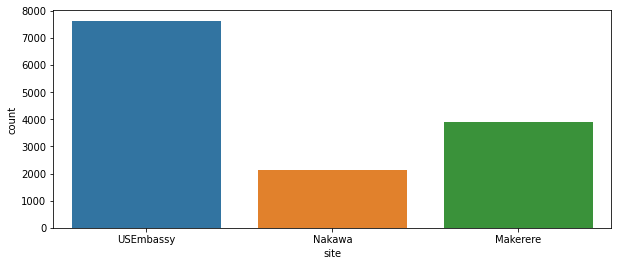

In [ ]:
#site

print(all_data["site"].value_counts(),"\n")
plt.figure(figsize=(10,4))
sns.countplot(x = all_data["site"])
plt.show()

USEmbassy    7635
Makerere     3884
Nakawa       2146
Name: site, dtype: int64 



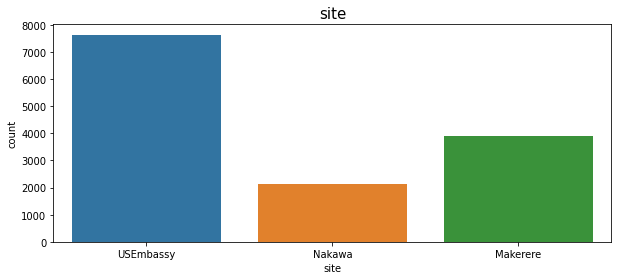

0.299255    7635
0.333501    3884
0.331740    2146
Name: lat, dtype: int64 



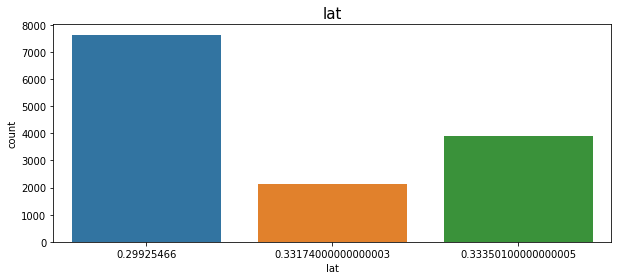

32.592686    7635
32.568561    3884
32.609510    2146
Name: long, dtype: int64 



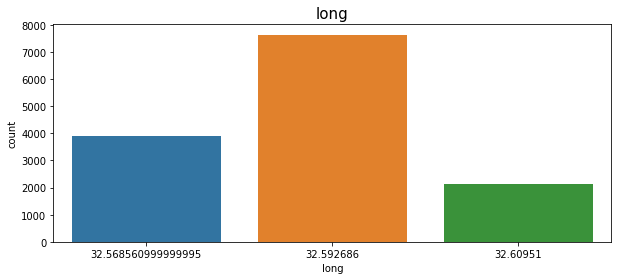

1199    7635
1233    3884
1191    2146
Name: altitude, dtype: int64 



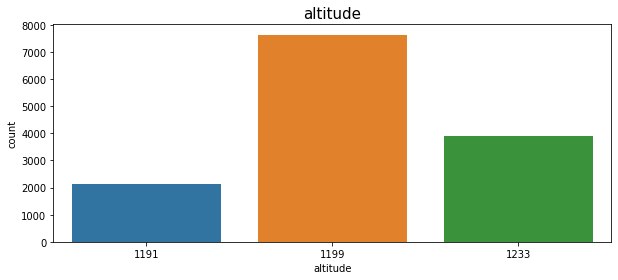

4374    7635
6340    3884
5865    2146
Name: greenness, dtype: int64 



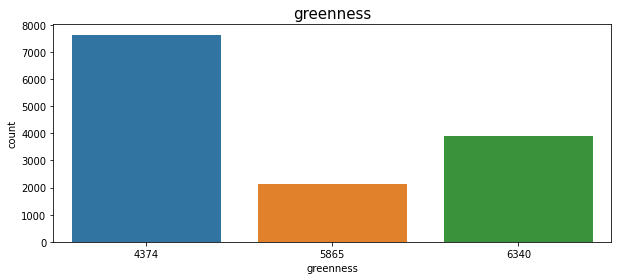

21    11519
31     2146
Name: landform_90m, dtype: int64 



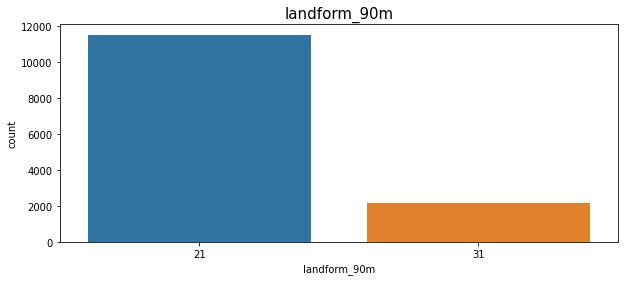

 14    7635
 28    3884
-11    2146
Name: landform_270m, dtype: int64 



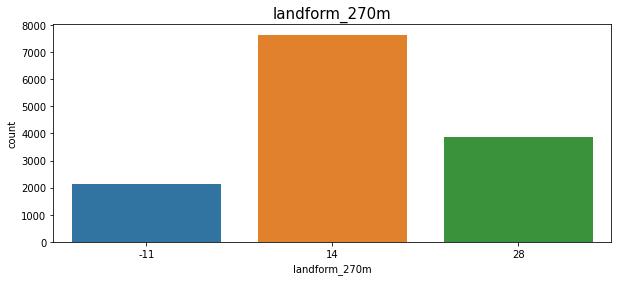

6834    7635
8518    3884
4780    2146
Name: population, dtype: int64 



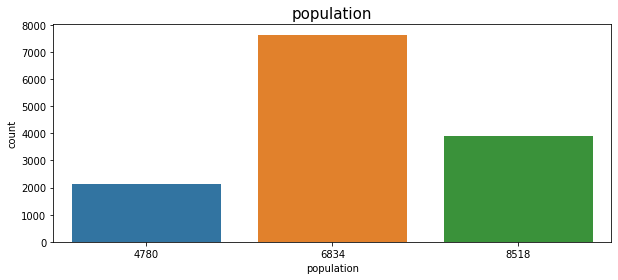

130    7635
475    3884
500    2146
Name: dist_major_road, dtype: int64 



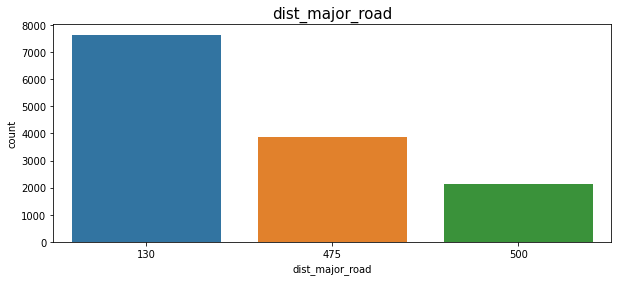

2020    8500
2019    2825
2021    2340
Name: year, dtype: int64 



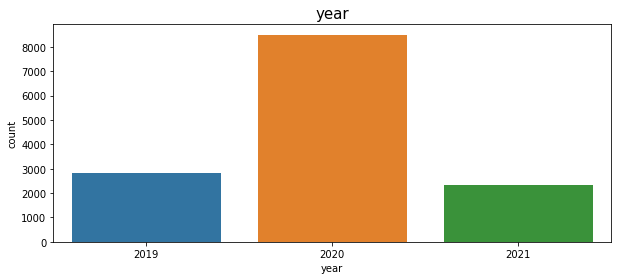

In [ ]:
for f in  l_4_f:
    data=all_data.copy()
    print(all_data[f].value_counts(),"\n")
    plt.figure(figsize=(10,4))
    plt.title(f, fontdict={'size':15})
    sns.countplot(x = all_data[f])
    plt.show()
    

In [ ]:
print(train.ref_pm2_5	.nunique(),"\n")
plt.subplot(121)
sns.distplot(train['ref_pm2_5'],color="b");

plt.subplot(122)
train['ref_pm2_5'].plot.box(figsize=(16,5))

plt.show()

#have some outliers must check it

In [ ]:
all_data.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,pa,year,month,hour,date
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,1,2020,4,17,23
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,1,2020,2,19,23
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,1,2021,1,4,23
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,1,2019,12,9,4
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,1,2019,10,1,1


In [ ]:
cat_cols = ['site','created_at']
num_cols = [col for col in all_data.columns if col not in cat_cols+['ID','pa','year','month','hour','date']]

In [ ]:
num_cols

['pm2_5',
 'pm10',
 's2_pm2_5',
 's2_pm10',
 'humidity',
 'temp',
 'lat',
 'long',
 'altitude',
 'greenness',
 'landform_90m',
 'landform_270m',
 'population',
 'dist_major_road',
 'ref_pm2_5']

13634 



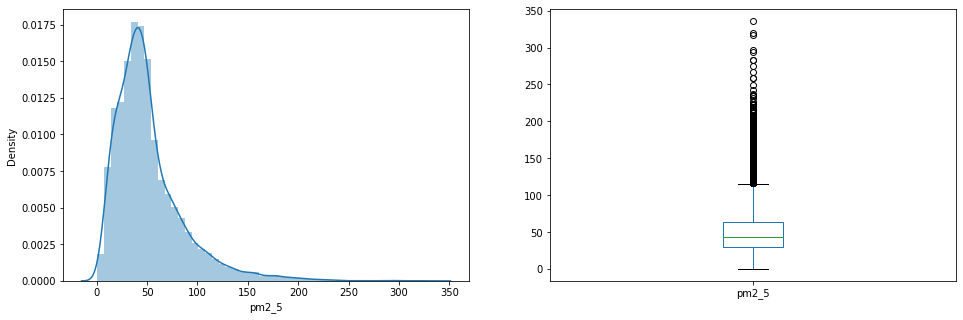

13633 



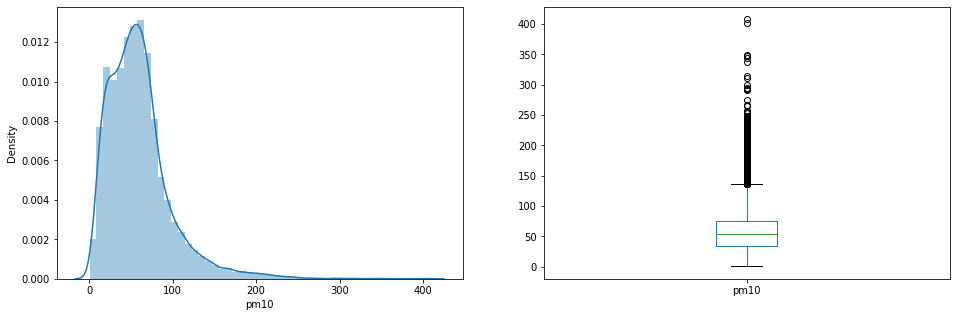

12999 



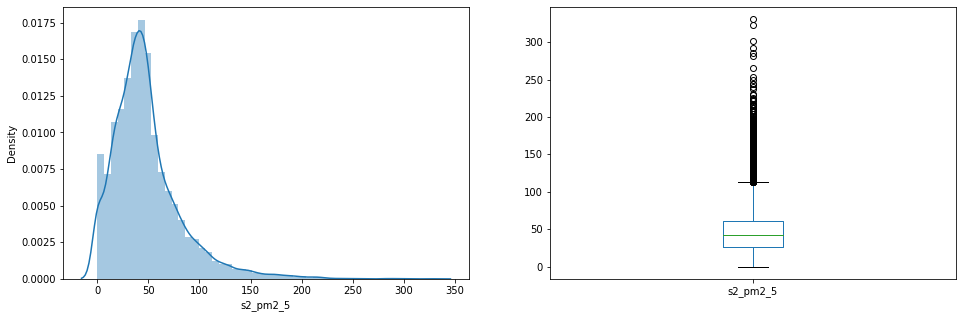

13015 



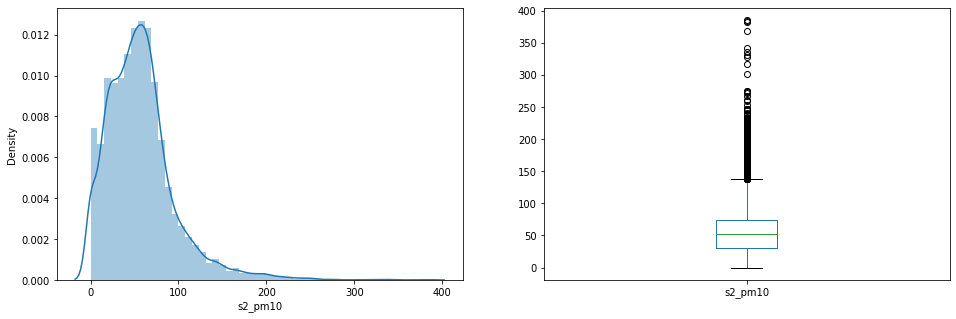

4625 



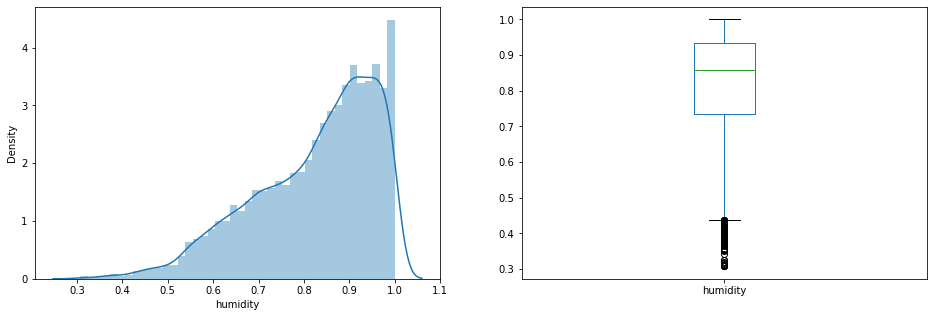

1642 



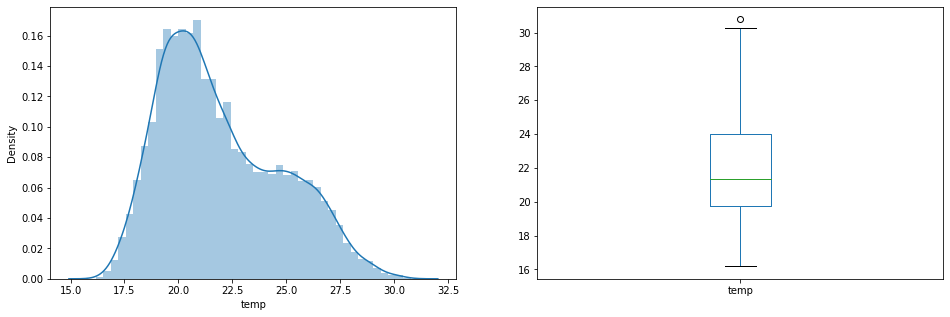

3 



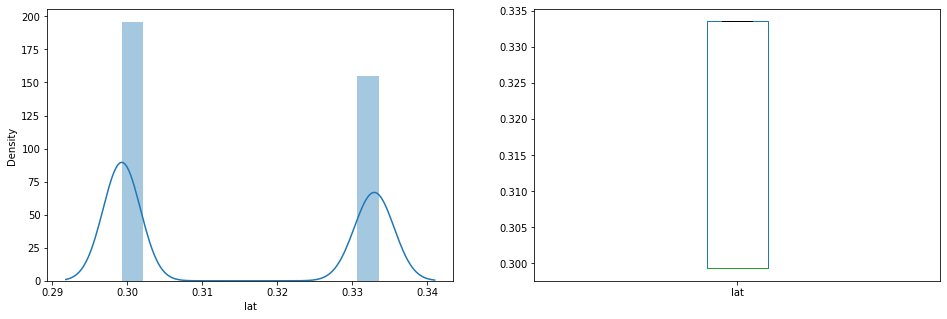

3 



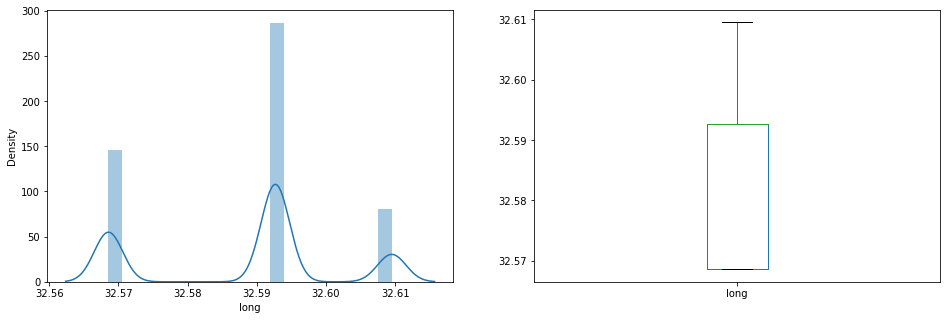

3 



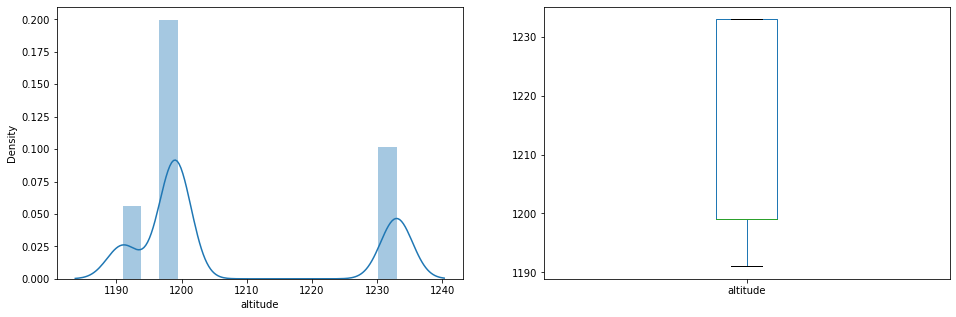

3 



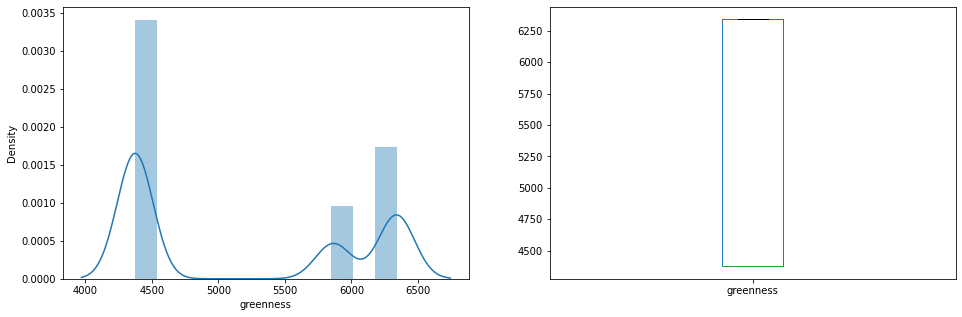

2 



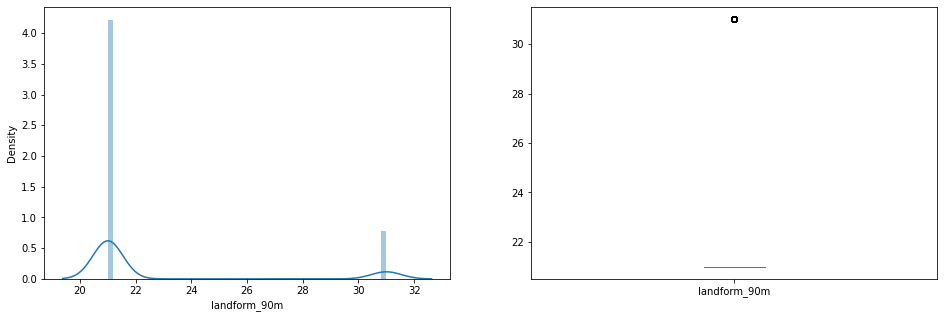

3 



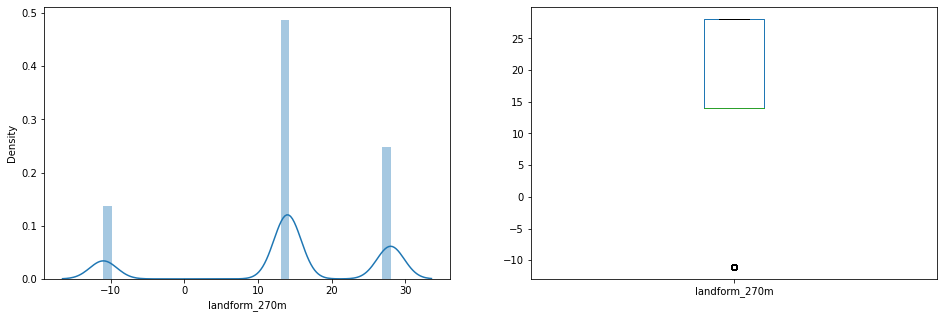

3 



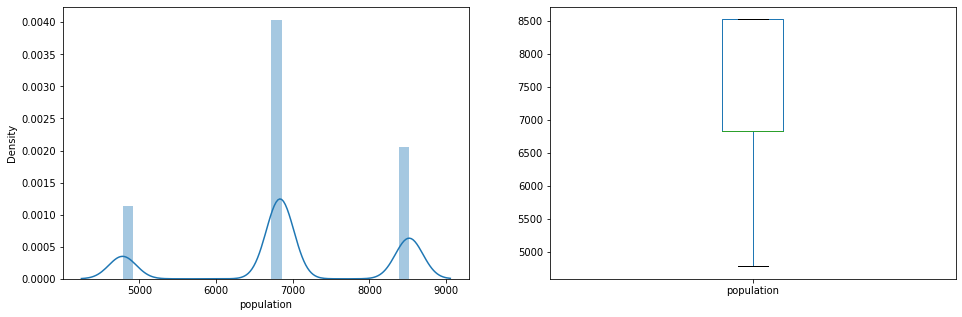

3 



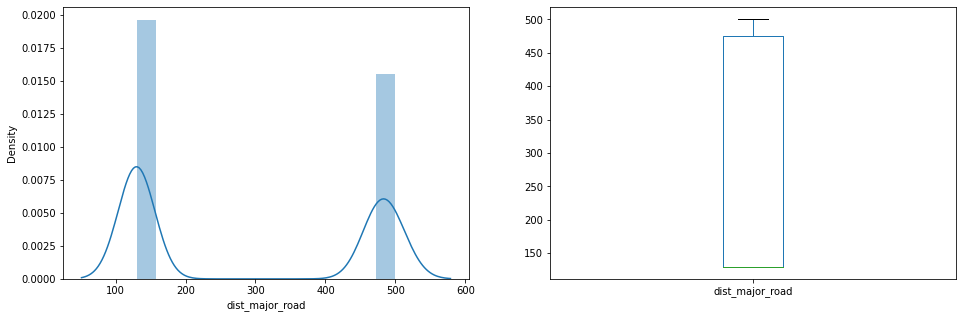

1233 



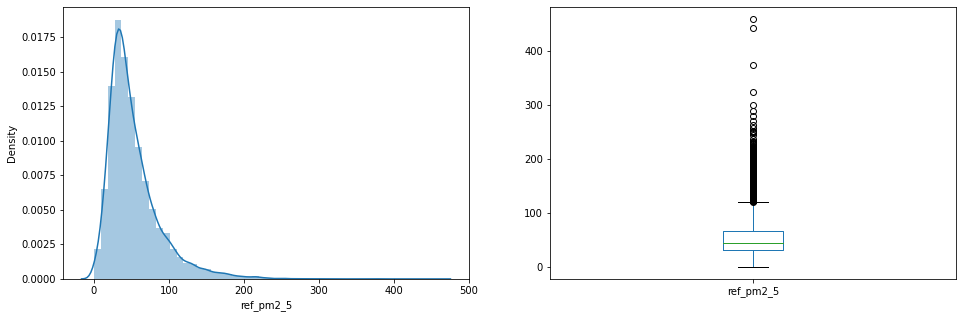

In [ ]:
for f in  num_cols:
    data=all_data.copy()
    plt.title(f, fontdict={'size':15})
    print(data[f].nunique(),"\n")
    plt.subplot(121)
    sns.distplot(data[f]);
    plt.subplot(122)
    train[f].plot.box(figsize=(16,5))
    plt.show()

In [ ]:
#all_data.loc[all_data.site=='USEmbassy']

In [ ]:
all_data["site"].unique()

array(['USEmbassy', 'Nakawa', 'Makerere'], dtype=object)

In [ ]:
site = all_data[["site"]]

site = pd.get_dummies(site, drop_first= True)


In [ ]:
ye = all_data[["year"]]

ye = pd.get_dummies(ye, drop_first= True)

In [ ]:
full_data= pd.concat([all_data,site], axis = 1)
full_data=full_data.drop(['site'],axis=1)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13665 entries, 0 to 13664
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               13665 non-null  object 
 1   created_at       13665 non-null  object 
 2   pm2_5            13665 non-null  float64
 3   pm10             13665 non-null  float64
 4   s2_pm2_5         13665 non-null  float64
 5   s2_pm10          13665 non-null  float64
 6   humidity         13658 non-null  float64
 7   temp             13644 non-null  float64
 8   lat              13665 non-null  float64
 9   long             13665 non-null  float64
 10  altitude         13665 non-null  int64  
 11  greenness        13665 non-null  int64  
 12  landform_90m     13665 non-null  int64  
 13  landform_270m    13665 non-null  int64  
 14  population       13665 non-null  int64  
 15  dist_major_road  13665 non-null  int64  
 16  ref_pm2_5        10932 non-null  float64
 17  pa          

In [ ]:
rel=[col for col in full_data.columns if col not in ['ID','pa','site', 'lat', 'long', 'altitude', 'greenness', 'landform_90m','landform_270m', 'population', 'dist_major_road']]

In [ ]:
rel

['created_at',
 'pm2_5',
 'pm10',
 's2_pm2_5',
 's2_pm10',
 'humidity',
 'temp',
 'ref_pm2_5',
 'year',
 'month',
 'hour',
 'date',
 'site_Nakawa',
 'site_USEmbassy']

In [ ]:
tr=full_data[full_data.pa==1]
tr=tr[rel]

In [ ]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10932 entries, 0 to 10931
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   created_at      10932 non-null  object 
 1   pm2_5           10932 non-null  float64
 2   pm10            10932 non-null  float64
 3   s2_pm2_5        10932 non-null  float64
 4   s2_pm10         10932 non-null  float64
 5   humidity        10926 non-null  float64
 6   temp            10915 non-null  float64
 7   ref_pm2_5       10932 non-null  float64
 8   year            10932 non-null  int64  
 9   month           10932 non-null  int64  
 10  hour            10932 non-null  int64  
 11  date            10932 non-null  int64  
 12  site_Nakawa     10932 non-null  uint8  
 13  site_USEmbassy  10932 non-null  uint8  
dtypes: float64(7), int64(4), object(1), uint8(2)
memory usage: 1.1+ MB


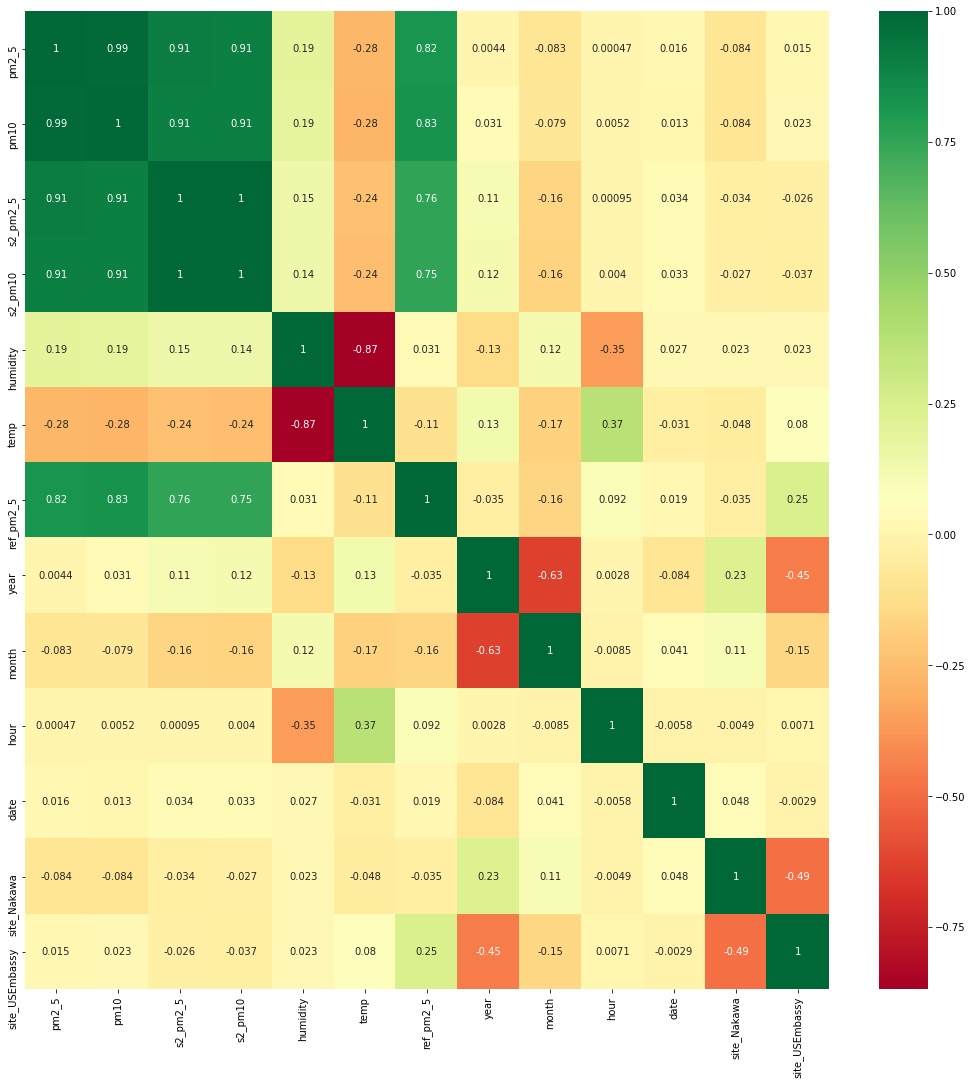

In [ ]:
plt.figure(figsize = (18,18))
sns.heatmap(tr.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [ ]:
t=tr[tr.isna().any(axis=1)]
ty=t[['humidity','temp','hour','site_Nakawa','site_USEmbassy']]
ty

,humidity,temp,hour,site_Nakawa,site_USEmbassy


In [ ]:
tr.head()

In [ ]:
def impute_nan(cols):
   hu  = cols[0]
   temp = cols[1]
   h    = cols[2]
    
   if pd.isnull(temp):

      if hu== 1 and h ==7 :
            return 17.733333
      if  hu== 1 and h ==6 :
            return 17.5   
      if h ==3:
            return 19.88
      if h ==2:
            return 19.19
      if h ==1:
            return 18.76     
      if h ==9:
            return 21.86 
      if h ==0:
            return 19.52
      if h ==10:
            return 22.13
      if h ==11:
            return 24.37 
      if hu!='NaN' and h==13:
            return 26 
      if h==12:
            return 24.99      
      if h==17:
            return 24.76
      if  hu== 0.72 and h ==16 :
            return 25.116
      if hu!='NaN' and h==15:
            return 25.62             
      elif hu==0.9975 and h==4:
            return 18
      else:
        pass      
   else:
      return temp  


      

In [ ]:
def hum(cols):
   hu  = cols[0]
   temp = cols[1]
   h    = cols[2]
    
   if pd.isnull(hu):

      if  h ==16 :
            return 0.7067
      if h==13:
            return 0.634583   
      if h ==14:
            return 0.704
      if h ==15:
            return 0.609
           
   else:
      return hu  


In [ ]:
20.66

In [ ]:
tr['temp'] = tr[['humidity','temp','hour']].apply(impute_nan,axis=1)

In [ ]:
tr['humidity'] = tr[['humidity','temp','hour']].apply(hum,axis=1)

In [ ]:
tr.loc[tr.index==866]

In [ ]:
217

In [ ]:
t=tr[tr.isna().any(axis=1)]
tn=t[['humidity','temp','hour','site_Nakawa','site_USEmbassy']]
tn

,humidity,temp,hour,site_Nakawa,site_USEmbassy


# test

In [ ]:
t_rel=['ID','created_at','pm2_5','pm10','s2_pm2_5','s2_pm10','humidity','temp','year','month','hour','date','site_Nakawa','site_USEmbassy']

In [ ]:
ts_1=full_data[full_data.pa==0]
ts_1=ts_1[t_rel]

In [ ]:
te=ts_1[ts_1.isna().any(axis=1)]
te=te[['humidity','temp','hour','site_Nakawa','site_USEmbassy','month']]
te

,humidity,temp,hour,site_Nakawa,site_USEmbassy,month


In [ ]:
def t_hum(cols):
   hu  = cols[0]
   temp = cols[1]
   h    = cols[2]
    
   if pd.isnull(temp):

      if  hu ==1 and h==8 :
            return 17.38
      if h==5:
            return 18.68   
      if h ==23:
            return 20.55
      if h ==14:
            return 24.408
           
   else:
      return temp  

In [ ]:
ts_1['temp'] = ts_1[['humidity','temp','hour']].apply(t_hum,axis=1)

In [ ]:
ts_1.fillna(0.68,inplace=True)

In [ ]:
#p=all_data.loc[(all_data.temp==23)]
#ml=p[['humidity','temp','hour','site','month']]
#ml

In [ ]:
#sns.scatterplot(x='humidity',y='temp',data=all_data)

In [ ]:
#there are some missing vales in humidity and temperature 

#lets replace them

#tem and humidity are related and with hour

tyi=all_data.groupby(['site','hour','month'])['temp','humidity'].agg(['mean','median','std'])
tyi.reset_index(inplace=True)


In [ ]:
tyi

In [ ]:
tyi.columns=['site','hour','month','temp_me','temp_med','t_std','h_mean','h_med','h_std']
tyi.loc[(tyi.site=='Nakawa') & (tyi.month==1)]

# model

In [ ]:
#tr.info()

In [ ]:
f_train=tr.drop(['date','created_at'],axis=1)

f_train['temp']=f_train['temp'].round(2)

f_train['humidity']=f_train['humidity'].round(3)

f_train['pm2_5']=f_train['pm2_5'].round(2)

f_train['s2_pm2_5']=f_train['s2_pm2_5'].round(2)

f_train['pm10']=f_train['pm10'].round(2)

f_train['s2_pm10']=f_train['s2_pm10'].round(2)


In [ ]:
f_train.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,ref_pm2_5,year,month,hour,site_Nakawa,site_USEmbassy
0,6.82,7.31,6.79,7.84,0.807,22.38,25.0,2020,4,17,0,1
1,57.46,67.88,55.64,70.65,0.712,25.35,68.0,2020,2,19,0,1
2,170.01,191.15,165.31,191.47,0.908,20.62,149.7,2021,1,4,1,0
3,49.73,61.51,0.00,0.00,0.950,21.22,54.0,2019,12,9,0,1
4,41.63,51.04,41.72,51.14,0.914,18.91,39.0,2019,10,1,0,1


**test_p**

In [ ]:
test_ff=ts_1.drop(['date','created_at'],axis=1)

test_ff['temp']=test_ff['temp'].round(2)

test_ff['humidity']=test_ff['humidity'].round(3)

test_ff['pm2_5']=test_ff['pm2_5'].round(2)

test_ff['s2_pm2_5']=test_ff['s2_pm2_5'].round(2)

test_ff['pm10']=test_ff['pm10'].round(2)

test_ff['s2_pm10']=test_ff['s2_pm10'].round(2)

test_ff.head()

,ID,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,year,month,hour,site_Nakawa,site_USEmbassy
10932,ID_00OZLF7X,31.90,35.52,31.67,37.05,0.927,21.18,2020,3,7,0,1
10933,ID_00ZI0D98,53.58,66.60,50.59,64.65,0.812,22.35,2020,8,10,0,0
10934,ID_017GTLAU,62.38,71.65,59.02,69.77,0.902,20.77,2020,8,9,0,0
10935,ID_01IBM7T2,33.31,36.96,33.06,38.67,0.643,25.48,2020,6,16,0,1
10936,ID_01II27D4,64.78,75.25,64.64,77.11,0.940,20.13,2021,1,0,1,0


In [ ]:
test_ff_r=test_ff.drop('ID',axis=1)

In [ ]:
test_ff_r.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,year,month,hour,site_Nakawa,site_USEmbassy
10932,31.90,35.52,31.67,37.05,0.927,21.18,2020,3,7,0,1
10933,53.58,66.60,50.59,64.65,0.812,22.35,2020,8,10,0,0
10934,62.38,71.65,59.02,69.77,0.902,20.77,2020,8,9,0,0
10935,33.31,36.96,33.06,38.67,0.643,25.48,2020,6,16,0,1
10936,64.78,75.25,64.64,77.11,0.940,20.13,2021,1,0,1,0


# model_main

In [ ]:
f_train['ref_pm2_5'] = np.log1p(f_train['ref_pm2_5'])

In [ ]:
f_train.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,ref_pm2_5,year,month,hour,site_Nakawa,site_USEmbassy
0,6.82,7.31,6.79,7.84,0.807,22.38,3.258097,2020,4,17,0,1
1,57.46,67.88,55.64,70.65,0.712,25.35,4.234107,2020,2,19,0,1
2,170.01,191.15,165.31,191.47,0.908,20.62,5.015291,2021,1,4,1,0
3,49.73,61.51,0.00,0.00,0.950,21.22,4.007333,2019,12,9,0,1
4,41.63,51.04,41.72,51.14,0.914,18.91,3.688879,2019,10,1,0,1


In [ ]:
y=f_train.ref_pm2_5
y

0        3.258097
1        4.234107
2        5.015291
3        4.007333
4        3.688879
           ...   
10927    4.356709
10928    3.135494
10929    3.555348
10930    3.577948
10931    3.891820
Name: ref_pm2_5, Length: 10932, dtype: float64

In [ ]:
X=f_train.drop(['ref_pm2_5'],axis=1)
#X.shape
X.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,year,month,hour,site_Nakawa,site_USEmbassy
0,6.82,7.31,6.79,7.84,0.807,22.38,2020,4,17,0,1
1,57.46,67.88,55.64,70.65,0.712,25.35,2020,2,19,0,1
2,170.01,191.15,165.31,191.47,0.908,20.62,2021,1,4,1,0
3,49.73,61.51,0.00,0.00,0.950,21.22,2019,12,9,0,1
4,41.63,51.04,41.72,51.14,0.914,18.91,2019,10,1,0,1


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10932 entries, 0 to 10931
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pm2_5           10932 non-null  float64
 1   pm10            10932 non-null  float64
 2   s2_pm2_5        10932 non-null  float64
 3   s2_pm10         10932 non-null  float64
 4   humidity        10932 non-null  float64
 5   temp            10932 non-null  float64
 6   year            10932 non-null  int64  
 7   month           10932 non-null  int64  
 8   hour            10932 non-null  int64  
 9   site_Nakawa     10932 non-null  uint8  
 10  site_USEmbassy  10932 non-null  uint8  
dtypes: float64(6), int64(3), uint8(2)
memory usage: 875.4 KB


In [ ]:
test_ff_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733 entries, 10932 to 13664
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pm2_5           2733 non-null   float64
 1   pm10            2733 non-null   float64
 2   s2_pm2_5        2733 non-null   float64
 3   s2_pm10         2733 non-null   float64
 4   humidity        2733 non-null   float64
 5   temp            2733 non-null   float64
 6   year            2733 non-null   int64  
 7   month           2733 non-null   int64  
 8   hour            2733 non-null   int64  
 9   site_Nakawa     2733 non-null   uint8  
 10  site_USEmbassy  2733 non-null   uint8  
dtypes: float64(6), int64(3), uint8(2)
memory usage: 218.9 KB


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42,shuffle=True)

In [ ]:
print(X_train.shape)
X_test.shape

(8745, 11)


(2187, 11)

In [ ]:
from sklearn.metrics import mean_squared_log_error
from math import sqrt

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 3000,
         'num_leaves': 69,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 1000
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_test)
print('RMSE:', (mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.277172
[200]	valid_0's rmse: 0.274556
[300]	valid_0's rmse: 0.275117
[400]	valid_0's rmse: 0.275308
Early stopping, best iteration is:
[237]	valid_0's rmse: 0.274338
RMSE: 0.07526128787892707


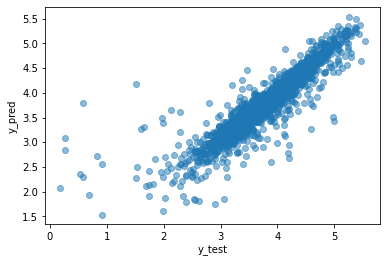

In [ ]:
plt.scatter((y_test),(y_pred_lgbm) ,alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
y_pred_lgbm_t = lgbm.predict(test_ff_r)


opui=np.expm1(y_pred_lgbm_t).round(2)

opui

array([ 43.09,  41.02,  46.  , ...,  35.95, 267.59,  96.17])

In [ ]:
final_data1 = {'ID ': test_ff['ID'], 'Response':opui }
submission7 = pd.DataFrame(data=final_data1)

In [ ]:
submission7

,ID,Response
10932,ID_00OZLF7X,43.09
10933,ID_00ZI0D98,41.02
10934,ID_017GTLAU,46.00
10935,ID_01IBM7T2,38.97
10936,ID_01II27D4,52.66
...,...,...
13660,ID_ZW5RSNUS,25.14
13661,ID_ZWCI817N,85.87
13662,ID_ZX5858FJ,35.95
13663,ID_ZY4XOL2H,267.59


In [ ]:
%cd "/content"
submission7.to_csv('first.csv', index =False)

/content


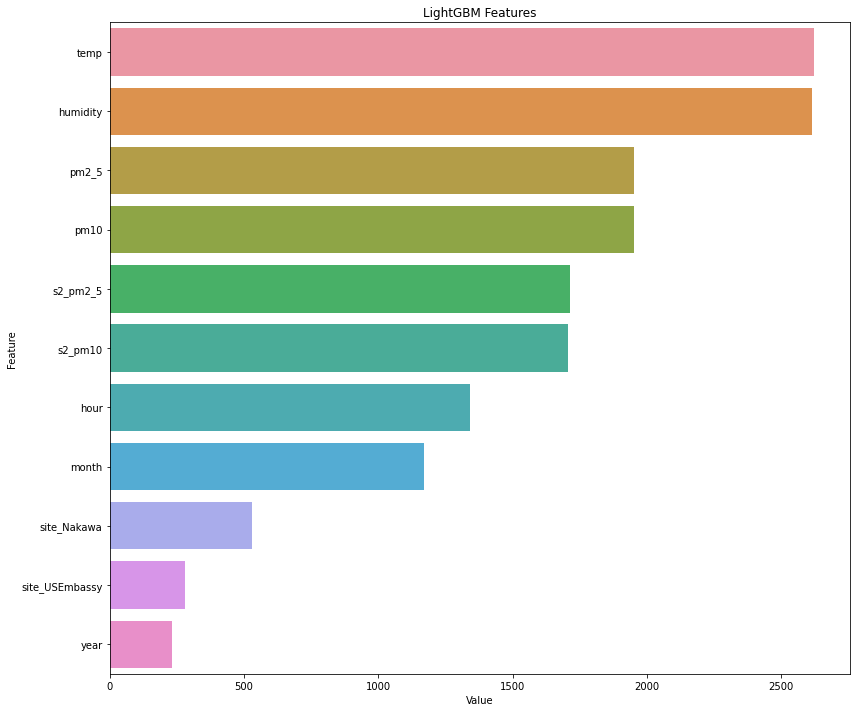

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(test_ff_r)
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.25512081533600117
RMSLE LGBM:  0.2652483455566673
RMSLE LGBM:  0.27607764163400034
RMSLE LGBM:  0.24367099826857466
RMSLE LGBM:  0.27388592505910947
RMSLE LGBM:  0.2902596675897257
RMSLE LGBM:  0.2634792167970104
RMSLE LGBM:  0.2735315436190063
RMSLE LGBM:  0.2511254525946334
RMSLE LGBM:  0.23199458901487754


In [ ]:
gb_fib = (np.mean(y_pred_totlgb,0))
gb_fib=np.expm1(gb_fib).round(2)

In [ ]:
gb_fib

array([ 41.22,  41.95,  46.05, ...,  36.94, 231.76, 100.61])

In [ ]:
final_data1 = {'ID ': test_ff['ID'], 'Response':gb_fib }
submission8 = pd.DataFrame(data=final_data1)

In [ ]:
%cd "/content"
submission8.to_csv('second.csv', index =False)

/content


In [ ]:
!pip install catboost
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
#from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
model = {
    "Decision Tree": DecisionTreeRegressor(),  
    "Random Forest" : RandomForestRegressor(), 
    "Gradient Boosting" : GradientBoostingRegressor(),
    "XGBoost" : XGBRegressor(),
    "CatBoost" : CatBoostRegressor(),
    "LGBM" : LGBMRegressor(),
    "linear":LinearRegression()
        }

In [ ]:
scores = []
prob_score = {}
for mod in model:
    classifier = model[mod]
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    try:
        score = classifier.predict_proba(X_test)[:,1]
        roc = sqrt(mean_squared_error(y_test, score))
        prob_score[mod] = score
    except:
        roc = 0
    scores.append([
        mod,
        mean_squared_error(y_test, pred),
        mean_squared_error(y_test, pred),
        mean_squared_error(y_test, pred),
        mean_squared_error(y_test, pred),
        roc
    ])

In [ ]:
def highlight_max(s):
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

scores_df  = pd.DataFrame(scores)
index_model = {count: s for count, s in enumerate(scores_df[0])}
col = {count+1: s for count, s in enumerate(['Accuracy','F1 Score','Precision','Recall','ROC AUC'])}
scores_df = scores_df.drop(0, axis=1)
scores_df = scores_df.rename(columns=col, index=index_model)
scores_df.style.apply(highlight_max)

,Accuracy,F1 Score,Precision,Recall,ROC AUC
Decision Tree,0.140537,0.140537,0.140537,0.140537,0
Random Forest,0.070458,0.070458,0.070458,0.070458,0
Gradient Boosting,0.060439,0.060439,0.060439,0.060439,0
XGBoost,0.059861,0.059861,0.059861,0.059861,0
CatBoost,0.051570,0.051570,0.051570,0.051570,0
LGBM,0.059491,0.059491,0.059491,0.059491,0
linear,0.118457,0.118457,0.118457,0.118457,0


In [ ]:
model1 = CatBoostRegressor()
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
print(f'mse score on the X_test is: {mean_squared_error(y_test, y_pred)}')

Learning rate set to 0.058634
0:	learn: 0.6291861	total: 4.12ms	remaining: 4.12s
1:	learn: 0.6057608	total: 7.71ms	remaining: 3.85s
2:	learn: 0.5842555	total: 11.2ms	remaining: 3.74s
3:	learn: 0.5646663	total: 14.8ms	remaining: 3.69s
4:	learn: 0.5458979	total: 18.4ms	remaining: 3.66s
5:	learn: 0.5292717	total: 22ms	remaining: 3.65s
6:	learn: 0.5137060	total: 25.5ms	remaining: 3.62s
7:	learn: 0.4986520	total: 29.3ms	remaining: 3.63s
8:	learn: 0.4848856	total: 32.8ms	remaining: 3.61s
9:	learn: 0.4722121	total: 36.3ms	remaining: 3.59s
10:	learn: 0.4606492	total: 39.8ms	remaining: 3.58s
11:	learn: 0.4501030	total: 43.3ms	remaining: 3.57s
12:	learn: 0.4399852	total: 46.9ms	remaining: 3.56s
13:	learn: 0.4309182	total: 50.5ms	remaining: 3.55s
14:	learn: 0.4222707	total: 53.9ms	remaining: 3.54s
15:	learn: 0.4144819	total: 57.4ms	remaining: 3.53s
16:	learn: 0.4076027	total: 61.2ms	remaining: 3.54s
17:	learn: 0.4010994	total: 64.7ms	remaining: 3.53s
18:	learn: 0.3950734	total: 68.2ms	remaining: 

In [ ]:
cc = model1.predict(test_ff_r)


cc=np.expm1(y_pred_lgbm_t)

cc

array([ 43.09279249,  41.01581328,  46.00422402, ...,  35.94683647,
       267.59199943,  96.1665872 ])

In [ ]:
final_data1 = {'ID ': test_ff['ID'], 'Response':cc }
sc = pd.DataFrame(data=final_data1)
sc

,ID,Response
10932,ID_00OZLF7X,43.092792
10933,ID_00ZI0D98,41.015813
10934,ID_017GTLAU,46.004224
10935,ID_01IBM7T2,38.969863
10936,ID_01II27D4,52.662879
...,...,...
13660,ID_ZW5RSNUS,25.135244
13661,ID_ZWCI817N,85.870186
13662,ID_ZX5858FJ,35.946836
13663,ID_ZY4XOL2H,267.591999


In [ ]:
%cd "/content"
sc.to_csv('c_1.csv', index =False)

/content


In [ ]:
from sklearn.model_selection import KFold

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    model1.fit(X_train, y_train,eval_set=[(X_test, y_test)], verbose=0)

    y_pred_lgbm = model1.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = model1.predict(test_ff_r)
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.2535014511430231
RMSLE LGBM:  0.2481086741006529
RMSLE LGBM:  0.2707416323391902
RMSLE LGBM:  0.2323462831968449
RMSLE LGBM:  0.26851155958244544
RMSLE LGBM:  0.27640606157641856
RMSLE LGBM:  0.26664696377103914
RMSLE LGBM:  0.27545795753483726
RMSLE LGBM:  0.24681560109808826
RMSLE LGBM:  0.2127963062160157


In [ ]:
gb_c = (np.mean(y_pred_totlgb,0))
gb_c=np.expm1(gb_c).round(2)

NameError: ignored

In [ ]:
gb_c

NameError: ignored

In [ ]:
final_data1 = {'ID ': test_ff['ID'], 'Response':gb_c }
c_2 = pd.DataFrame(data=final_data1)
c_2

NameError: ignored

In [ ]:
%cd "/content"
c_2.to_csv('c_2.csv', index =False)

/content


NameError: ignored